In [135]:
import sklearn
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
from eli5 import show_weights, show_prediction
from xgboost import plot_importance
import seaborn as sns
from sklearn.manifold import TSNE

#custom
from py.helper import DataProcessing
from py.ml_metrics import plot_confusion_matrix

In [84]:
# set K-mer length here
kmer = 4

In [3]:
orf1 = DataProcessing('coronavirus_orf1ab.fasta', 'coronavirus_orf1ab_meta.csv')

In [6]:
#this will take a while
# kmers = orf1.get_amino_kmer_df(4)
amino_df = orf1.get_amino_df()
print(amino_df.shape)
amino_df.drop_duplicates(subset='Accession', keep=False, inplace=True)
print(amino_df.shape)
amino_df.head()

(3046, 10)
(2384, 10)


Accession          Release_Date                        Species  Length  \
1  YP_009555238  2019-02-21T00:00:00Z              Betacoronavirus 1    7095   
2  YP_002308478  2018-08-24T00:00:00Z       Bulbul coronavirus HKU11    6264   
3  YP_009513008  2018-08-24T00:00:00Z         Hedgehog coronavirus 1    7150   
4  YP_009513020  2018-08-24T00:00:00Z              Coronavirus HKU15    6267   
5  YP_009389424  2017-07-14T00:00:00Z  Wencheng Sm shrew coronavirus    6324   

       Geo_Location                 Host Isolation_Source Collection_Date  \
1               USA                  NaN              NaN             NaN   
2         Hong Kong   Pycnonotus jocosus              NaN         2007-01   
3           Germany  Erinaceus europaeus            feces            2012   
4  China: Hong Kong           Sus scrofa              NaN            2010   
5             China       Suncus murinus              NaN            2015   

                                       GenBank_Title  \
1                    Orf1ab [Human coronavirus OC43]   
2  orf1ab polyprotein [Bulbul coronavirus HKU11-934]   
3    orf1ab [Betacoronavirus Erinaceus/VMC/DEU/2012]   
4  replicase polyprotein [Porcine coronavirus HKU15]   
5  ORF1ab polyprotein [Wencheng Sm shrew coronavi...   

                                                 seq  
1  MSKINKYGLELHWAPEFPWMFEDAEEKLDNPSSSEVDMICSTTAQK...  
2  MVKNVSKRSPIVLPQIQPPPLQLFIAVAAAEEGHPKDLKYLGNYNL...  
3  MSSATGEGSQGARATYRAALNNEKRHDHVALTVPCCGTEAKVTALS...  
4  MAKNKSKRDAIALPENVPPPLQLFIHVAAAEEGHPKVTTYLGNYNL...  
5  MSVSKVELFVPISDEVDATHFGTFGDAVEAYASAAPSFEGVYFVAY...

Split the data

In [139]:
#split dataframe
mask = np.random.rand(len(amino_df)) < 0.8
train_df = amino_df[mask]
test_df = amino_df[~mask]
print(f'Size of the test df: {len(test_df)}. Size of the tain df: {len(train_df)}.')

Size of the test df: 501. Size of the tain df: 1883.


In [140]:
#split
xtrain = train_df['seq'].values
xtest = test_df['seq'].values

In [141]:
#vectorize
ctv = CountVectorizer(analyzer='char', ngram_range=(kmer, kmer), lowercase=False) # kmer: k-mer length

ctv.fit(list(xtrain)+list(xtest))
xtrain_ctv = ctv.transform(xtrain)
xtest_ctv = ctv.transform(xtest)

In [156]:
#K-means clustering
def run_kmeans(k):
    class_dict = dict(zip(range(k), [f'cluster_{i}' for i in range(k)]))
    kmeans = MiniBatchKMeans(n_clusters=k,verbose=0, batch_size=100)
    ytrain = kmeans.fit_predict(xtrain_ctv)
    ytest = kmeans.fit_predict(xtest_ctv)
    return ytrain, ytest, class_dict

F1 Score:  0.024522095050405514
Accuracy: 0.05189620758483034
dict_values(['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8'])
Normalized confusion matrix
[[0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.75 0.   0.   0.   0.12 0.   0.13]
 [0.   0.   0.   0.   1.   0.   0.   0.   0.  ]
 [1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.93 0.   0.   0.   0.   0.07]
 [0.   0.   0.   0.   0.   0.44 0.   0.39 0.17]
 [0.   0.   0.   0.   0.   0.   0.   0.   1.  ]
 [0.   0.   0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   1.  ]]


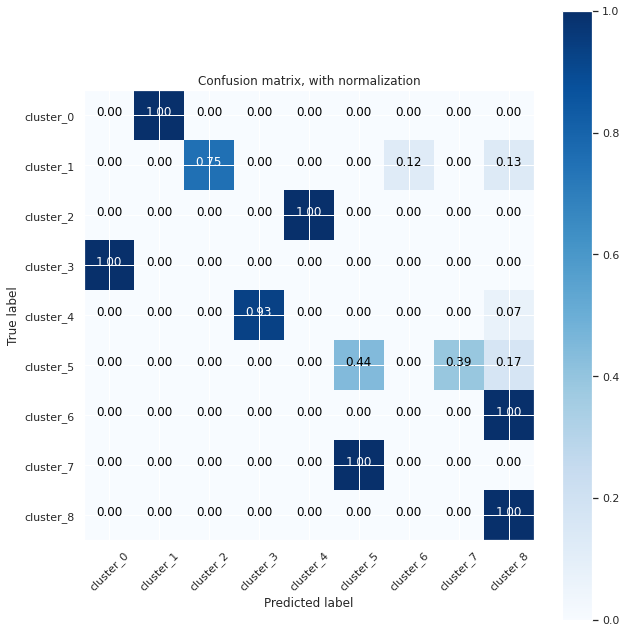

In [157]:
ytrain, ytest, class_dict = run_kmeans(9)
#fit logistic regression on CountVectorizer
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=1.0, max_iter=4000)
clf.fit(xtrain_ctv, ytrain)
predictions = clf.predict_proba(xtest_ctv)
evaluate_model(predictions, ytest, class_dict)

In [158]:
from eli5 import show_weights
# show_weights(clf, target_names=class_dict, vec=ctv)
show_weights(clf, vec=ctv, top=25, feature_filter=lambda x: x != '<BIAS>', target_names=class_dict)

[t-SNE] Computing 601 nearest neighbors...
[t-SNE] Indexed 1883 samples in 0.040s...
[t-SNE] Computed neighbors for 1883 samples in 14.054s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1883
[t-SNE] Computed conditional probabilities for sample 1883 / 1883
[t-SNE] Mean sigma: 9.529605
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.852798
[t-SNE] KL divergence after 1000 iterations: 0.200451


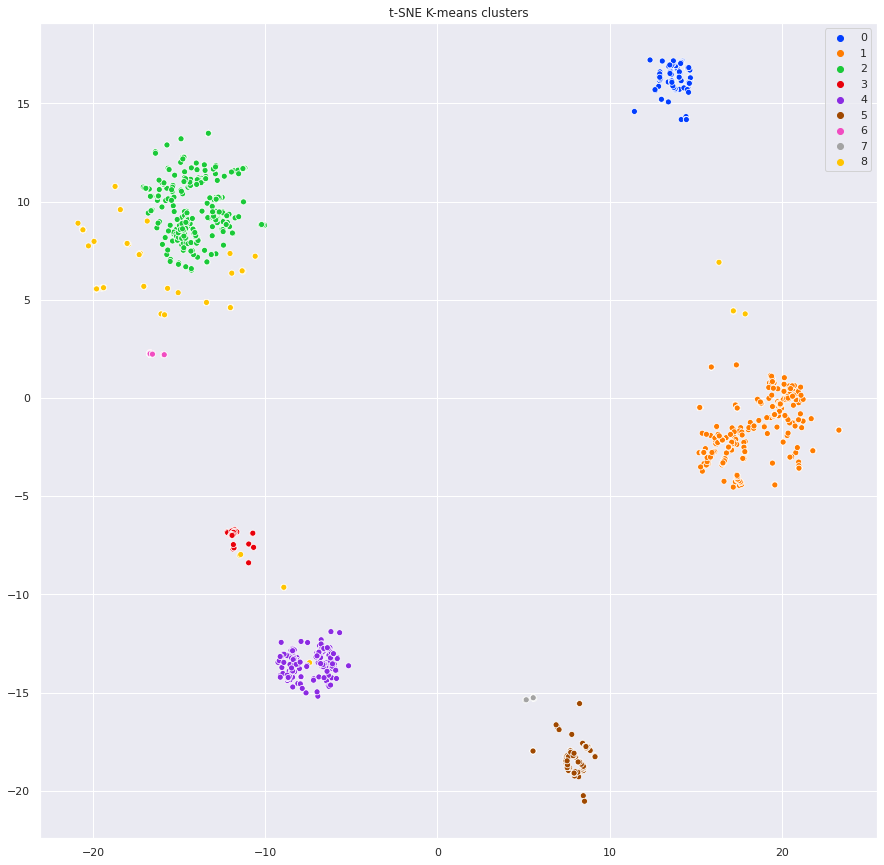

In [167]:
plot_tsne(xtrain_ctv, ytrain, 200)

In [164]:
predict_analyze_labelled(10, ctv, clf, xtest_ctv, xtest ,class_dict, highlight=True)

Row ID: 10| Text : MSFVAGVAPQGARGKYRAELNTEKRTDHVSLKASLCDAGDLVLKISPWFMDGESAYKHVSEQLSKGSKLLFVPQTLKGFIRHLPGPRVYLVERLTGGTYSDPFMVNQLAYQNAAGEGVIGTTLQGKRVGMFFPFDADLVTGEFQFLLRKKGFGGNRFRDAPWDYNWTPYSDLMDALEADPCGKYSQSLLKKLVGGDFTPIDQYMCGKNGKPIAEFAALMASEGITKLADVEAEVKSRTDSDRYIVFKNKLYRIVWNVQRKDVAYSKQSAFTMNSIVQLDTMEDVPRHSFTIGSEIQVIAPSTAVQANGHLNLKQRLLYAFYGKQAVSEPNYIYHSAYVDCTSCGKGSWLTGNAVQGFACDCGAHYCANDVDLQSSGLVRKNAVLLTTCPCNKDGECKHTLPQLVSMMTDKCDVEVVGKTFILTYGGVIYAYMGCSGGTMHFIPRAKSCVSKIGDAIFTGCTGTWSKVCETANLFLERAQHAINFVNEFVLTETVVALLSGTTSSIEELRDLCRNATFEKVRDYLTPRGWIVTMGSYIEGVINVGAAGVCNAALNAPFIVLSGLGESFKKVAATPWKLCSSLRETLDHYADSITYRVFPYDIPCDVTDYTALLLDCAVLTGASAYFVARYVDEKVEQLTNLVFSSCQSAVAAFVQACMSTYKATAKFISDMFTLIKVVSERLYVYTSVGFVVVGDYSSQLLKQFMHILSKAMQLLHTTVSWAGSKLPSVVYNGRDSLVFPSGTYYCVSTQGRSLQDQFDLVIPGDLSKKQIGILEPTPNSTTVDKKINTNVVEVVVGQLEPTKEHSPELVVGDYVIISNKIFVRSVEDSETVFYPLCTDGKIVPTLFRLKGGAPPKGVKFGGEQTKEITAVRSVSVDYDVHPVLDALLAGSELATFTVEKDLPVKDFVDVVKDEVIELLSKLLRGYNVDGFDLEDFADTPCYVYNAEGDLAWSSTMTFSVNPVEEVEEECDDDYVEDEYLSE

/home/aneesh/Projects/covid_bh_ml/lib/python3.6/site-packages/lime/lime_text.py:114: FutureWarning:

split() requires a non-empty pattern match.



Predicted class = cluster_1
Explanation for class cluster_1
('MSFVAGVAPQGARGKYRAELNTEKRTDHVSLKASLCDAGDLVLKISPWFMDGESAYKHVSEQLSKGSKLLFVPQTLKGFIRHLPGPRVYLVERLTGGTYSDPFMVNQLAYQNAAGEGVIGTTLQGKRVGMFFPFDADLVTGEFQFLLRKKGFGGNRFRDAPWDYNWTPYSDLMDALEADPCGKYSQSLLKKLVGGDFTPIDQYMCGKNGKPIAEFAALMASEGITKLADVEAEVKSRTDSDRYIVFKNKLYRIVWNVQRKDVAYSKQSAFTMNSIVQLDTMEDVPRHSFTIGSEIQVIAPSTAVQANGHLNLKQRLLYAFYGKQAVSEPNYIYHSAYVDCTSCGKGSWLTGNAVQGFACDCGAHYCANDVDLQSSGLVRKNAVLLTTCPCNKDGECKHTLPQLVSMMTDKCDVEVVGKTFILTYGGVIYAYMGCSGGTMHFIPRAKSCVSKIGDAIFTGCTGTWSKVCETANLFLERAQHAINFVNEFVLTETVVALLSGTTSSIEELRDLCRNATFEKVRDYLTPRGWIVTMGSYIEGVINVGAAGVCNAALNAPFIVLSGLGESFKKVAATPWKLCSSLRETLDHYADSITYRVFPYDIPCDVTDYTALLLDCAVLTGASAYFVARYVDEKVEQLTNLVFSSCQSAVAAFVQACMSTYKATAKFISDMFTLIKVVSERLYVYTSVGFVVVGDYSSQLLKQFMHILSKAMQLLHTTVSWAGSKLPSVVYNGRDSLVFPSGTYYCVSTQGRSLQDQFDLVIPGDLSKKQIGILEPTPNSTTVDKKINTNVVEVVVGQLEPTKEHSPELVVGDYVIISNKIFVRSVEDSETVFYPLCTDGKIVPTLFRLKGGAPPKGVKFGGEQTKEITAVRSVSVDYDVHPVLDALLAGSELATFTVEKDLPVKDFVDVVKDEVIELLSKLLRGYNVDGFDLEDFADT

In [123]:
def fit_and_predict_xgb(clf, xtrain_ctv, ytrain, xtest_ctv):
    # Fitting a simple xgboost on CountVectorizer
    clf = xgb.XGBClassifiaer(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                            subsample=0.8, nthread=10, learning_rate=0.1)
    clf.fit(xtrain_ctv, ytrain)
    return clf.predict_proba(xtest_ctv)

In [124]:
def evaluate_model(predictions, ytest, class_dict):
    y_pred = []
    for i in predictions:
        y_pred.append(i.argmax())

    print('F1 Score: ',sklearn.metrics.f1_score(ytest, y_pred, average='weighted'))
    print('Accuracy:', sklearn.metrics.accuracy_score(ytest, y_pred))
    from sklearn.metrics import confusion_matrix
    class_names = class_dict.values()
    print(class_names)
    cnf_matrix = confusion_matrix(ytest, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure(figsize=(9, 9))
    plot_confusion_matrix(cnf_matrix, class_names, True,
                          title='Confusion matrix, with normalization')
    plt.show()

Number of labels: 4
F1 Score:  0.0020881591108778256
Accuracy: 0.0019455252918287938
dict_values([0, 1, 2, 3])
Normalized confusion matrix
[[0.   0.   1.   0.  ]
 [0.74 0.   0.   0.26]
 [0.   0.99 0.01 0.  ]
 [0.   0.   1.   0.  ]]


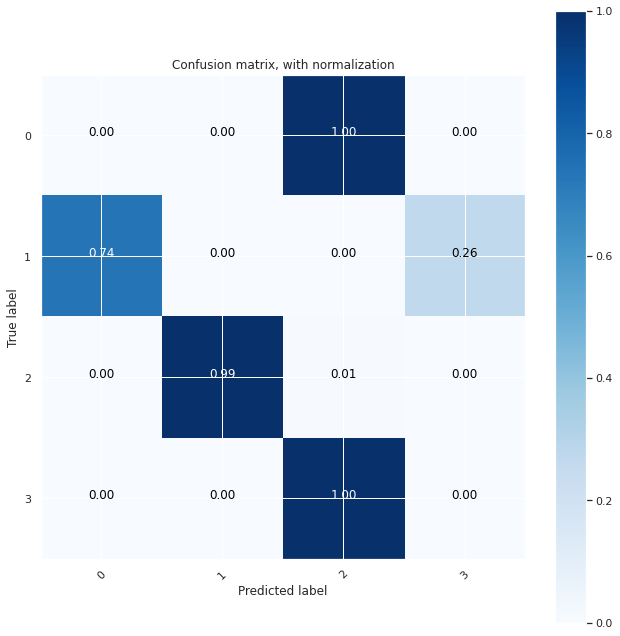

Number of labels: 5
F1 Score:  0.08949416342412451
Accuracy: 0.08949416342412451
dict_values([0, 1, 2, 3, 4])
Normalized confusion matrix
[[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]]


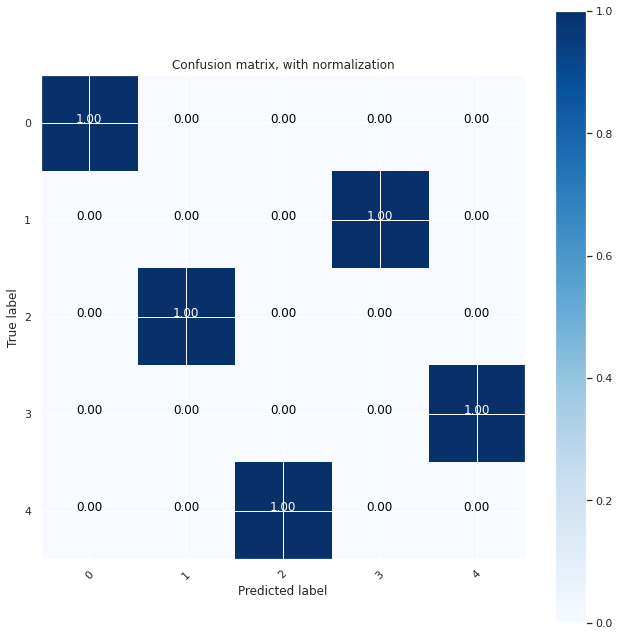

Number of labels: 6
F1 Score:  0.0
Accuracy: 0.0
dict_values([0, 1, 2, 3, 4, 5])
Normalized confusion matrix
[[0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]]


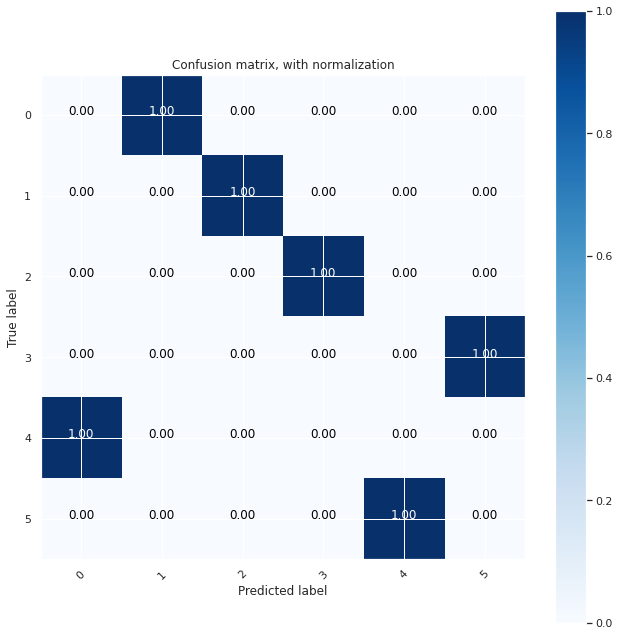

Number of labels: 7
F1 Score:  0.2490272373540856
Accuracy: 0.2490272373540856
dict_values([0, 1, 2, 3, 4, 5, 6])
Normalized confusion matrix
[[0.   0.68 0.   0.   0.   0.32 0.  ]
 [0.   0.   0.99 0.   0.   0.01 0.  ]
 [1.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.12 0.88]
 [0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.  ]]


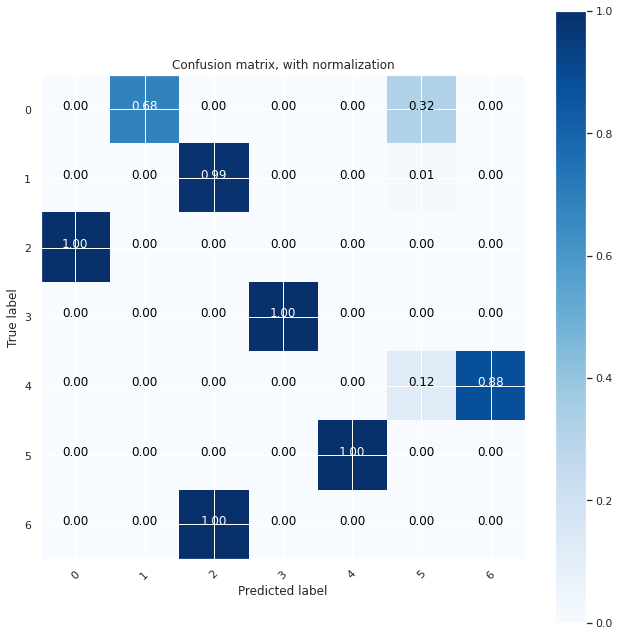

Number of labels: 8
F1 Score:  0.0
Accuracy: 0.0
dict_values([0, 1, 2, 3, 4, 5, 6, 7])
Normalized confusion matrix
[[0.   1.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.  ]
 [1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.89 0.   0.   0.   0.   0.11]
 [0.   0.   0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.02 0.   0.98 0.   0.  ]]


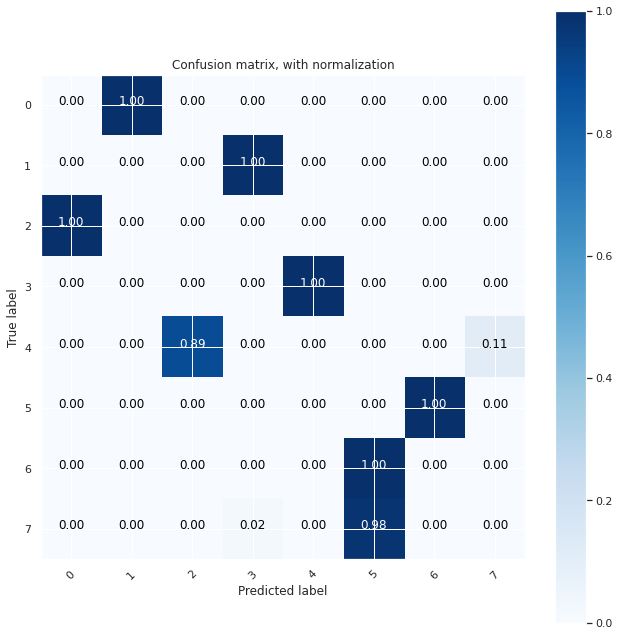

Number of labels: 9
F1 Score:  0.43068004992027115
Accuracy: 0.4066147859922179
dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8])
Normalized confusion matrix
[[0.89 0.   0.   0.   0.   0.   0.   0.11 0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.25 0.   0.   0.75]
 [0.   0.   0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   1.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.   0.  ]]


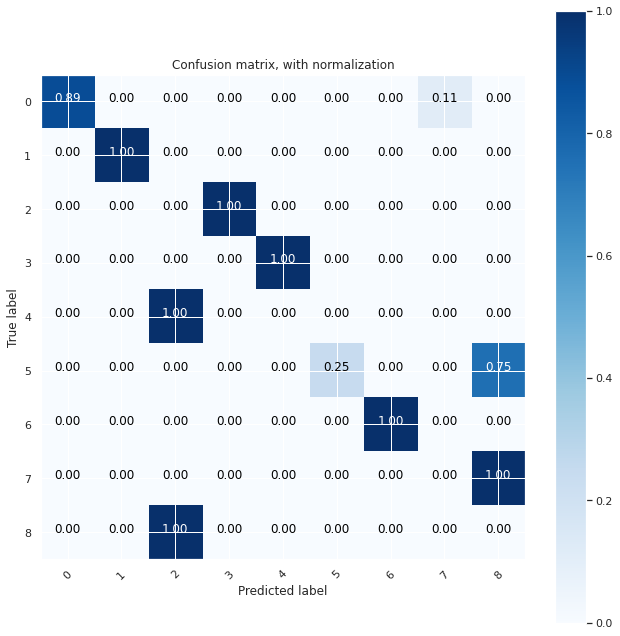

Number of labels: 10
F1 Score:  0.08949416342412451
Accuracy: 0.08949416342412451
dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Normalized confusion matrix
[[0.   0.   0.   0.   0.   0.   0.   0.   0.   1.  ]
 [1.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.89 0.   0.   0.   0.11 0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   1.   0.   0.   0.  ]]


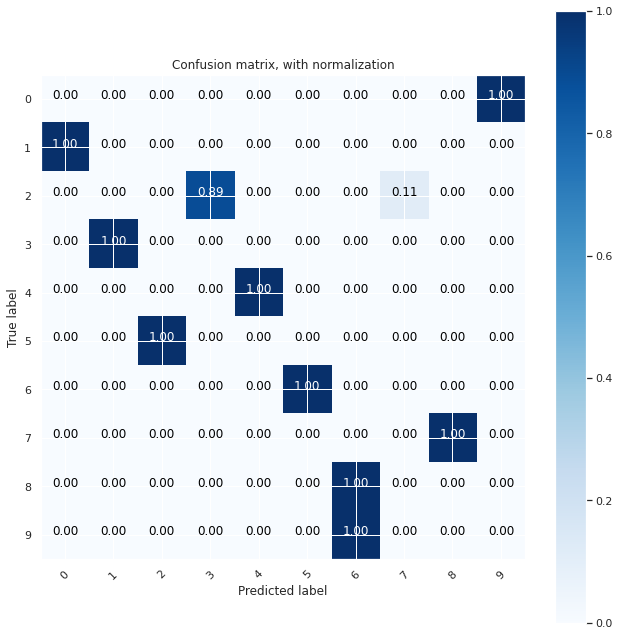

Number of labels: 11
F1 Score:  0.4102601760992659
Accuracy: 0.4027237354085603
dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
Normalized confusion matrix
[[0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.  ]
 [0.54 0.   0.   0.   0.   0.   0.   0.46 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.08 0.   0.   0.04 0.   0.   0.42 0.   0.46 0.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]]


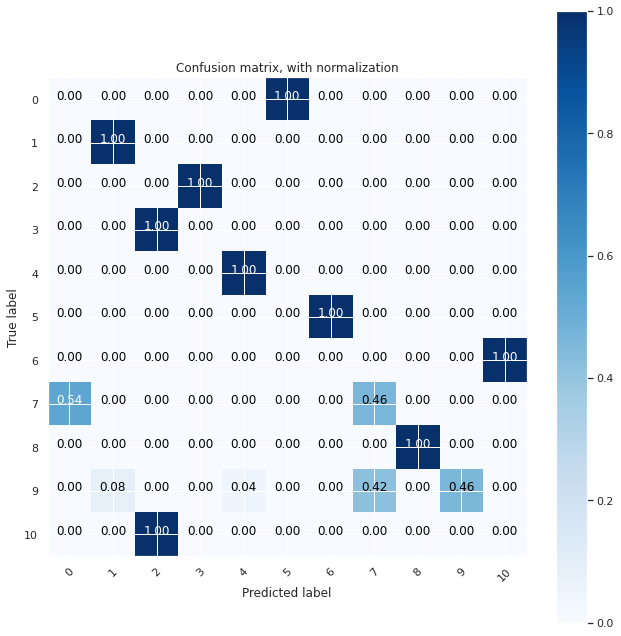

Number of labels: 12
F1 Score:  0.0005807538184563563
Accuracy: 0.0038910505836575876
dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
Normalized confusion matrix
[[0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.5  0.   0.   0.2  0.   0.   0.   0.   0.   0.   0.   0.3 ]
 [0.12 0.   0.   0.   0.   0.   0.   0.   0.   0.88 0.   0.  ]
 [0.   0.   0.   0.   0.54 0.   0.   0.   0.46 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.  ]
 [1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.  ]
 [0.92 0.   0.   0.   0.   0.   0.08 0.   0.   0.   0.   0.  ]]


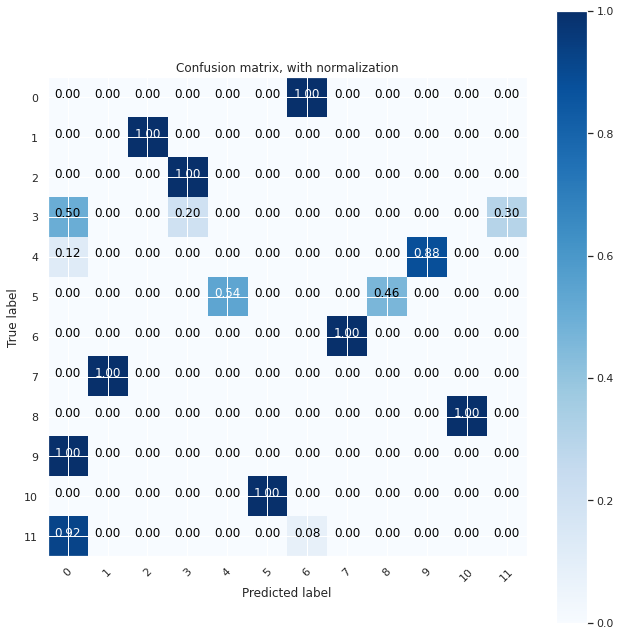

Number of labels: 13
F1 Score:  0.07920309262721713
Accuracy: 0.0914396887159533
dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
Normalized confusion matrix
[[1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.84 0.   0.   0.   0.   0.   0.16 0.  ]
 [0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.82 0.   0.   0.   0.   0.18]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.94 0.   0.06 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.  ]
 [0.06 0.   0.   0.   0.   0.   0.   0.   0.   0.94 0.   0.   0.  ]
 [0.   0.   0.26 0.

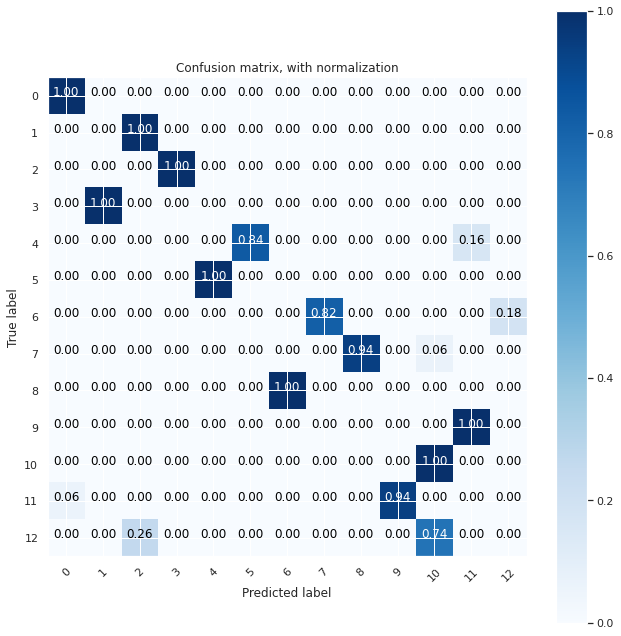

Number of labels: 14
F1 Score:  0.23202503806462527
Accuracy: 0.23735408560311283
dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
Normalized confusion matrix
[[1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.06 0.   0.   0.   0.   0.   0.   0.   0.94 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.03 0.39 0.   0.   0.   0.58]
 [0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.08 0.   0.   0.   0.92 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   1.   0.   0.   

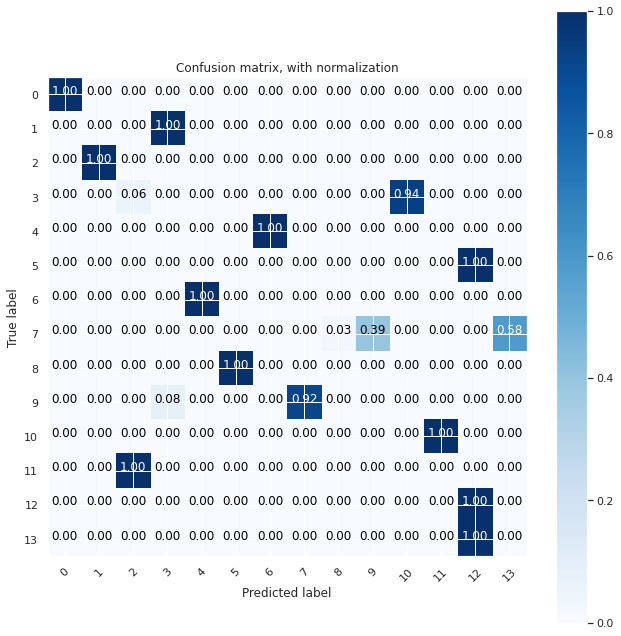

Number of labels: 15
F1 Score:  0.17880122217499192
Accuracy: 0.1828793774319066
dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
Normalized confusion matrix
[[0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.  ]
 [1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.  ]
 [0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.
  0.  ]
 [0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.47 0.06 0.   0.09 0.   0.38
  0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.
  0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.
  0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.
  0.  ]
 [0.   0.   0.   0.   0.   1.   0.   0.   0. 

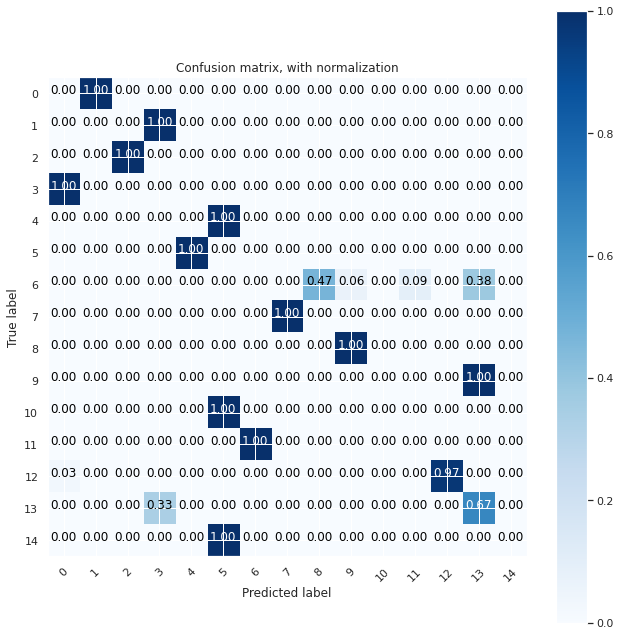

Number of labels: 16
F1 Score:  0.19298355717334
Accuracy: 0.1867704280155642
dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
Normalized confusion matrix
[[0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.
  0.   0.  ]
 [0.   0.   0.95 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.05 0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.
  0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.  ]
 [1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.  ]
 [0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.
  0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.
  0.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.55 0.   0.   0.   0.
  0.   0.

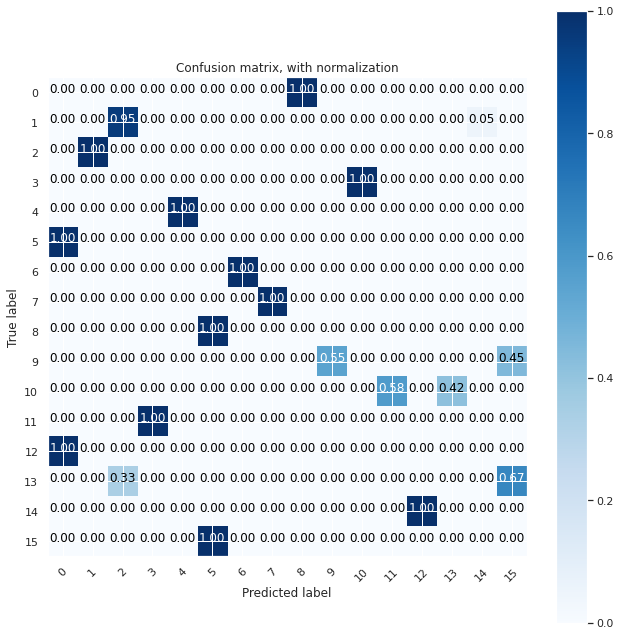

Number of labels: 17
F1 Score:  0.24550573592046496
Accuracy: 0.24319066147859922
dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])
Normalized confusion matrix
[[0.   0.   0.   0.   0.98 0.   0.   0.   0.   0.   0.   0.02 0.   0.
  0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.  ]
 [0.   0.   0.06 0.   0.   0.   0.   0.   0.   0.94 0.   0.   0.   0.
  0.   0.   0.  ]
 [1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.
  0.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   1.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.
  0.   0.   0.  ]
 [0.   0.   1.   0.   0.  

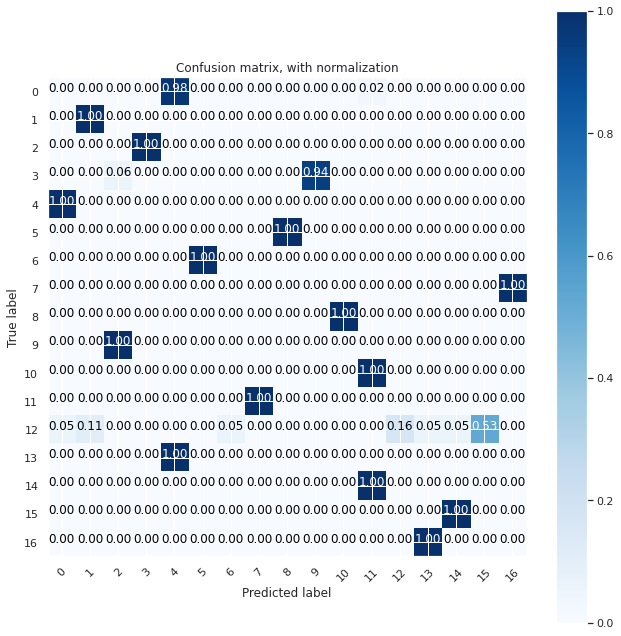

Number of labels: 18
F1 Score:  0.2688990322258805
Accuracy: 0.22762645914396887
dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17])
Normalized confusion matrix
[[0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.  ]
 [0.   0.57 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.02 0.41]
 [1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.92 0.   0.   0.   0.   0.   0.   0.08 0.
  0.   0.   0.   0.  ]
 [1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.
  0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.
 

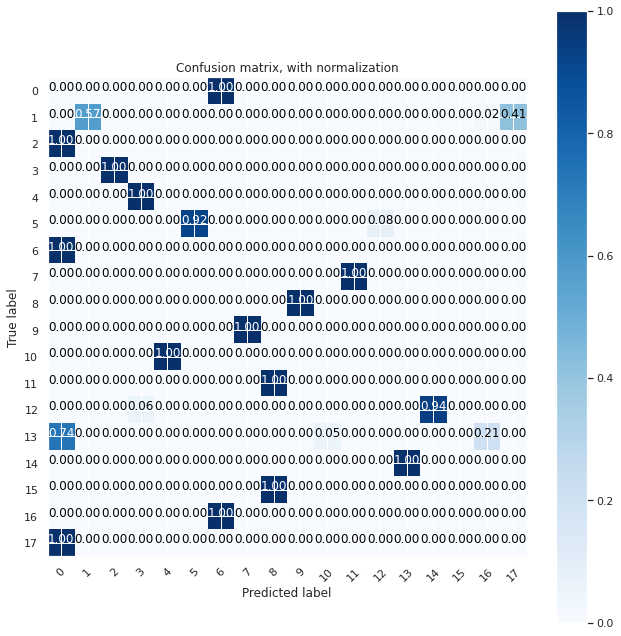

Number of labels: 19
F1 Score:  0.00012352541535420912
Accuracy: 0.0038910505836575876
dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])
Normalized confusion matrix
[[1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.  ]
 [1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   1.   0.  ]
 [0.   0.   0.93 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.07 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.
  0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.  

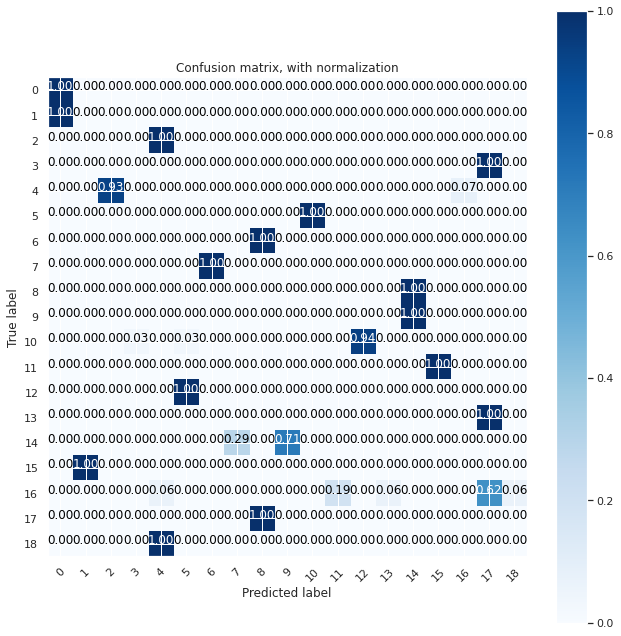

In [126]:
for k in range(4, 20):
    # run k-means
    ytrain, ytest, class_dict = run_kmeans(k)
    print('Number of labels: {}'.format(max(ytrain)+1))
    class_dict = dict(zip(range(k), range(k)))
    class_dict

    # make predictions
    predictions = fit_and_predict_xgb(clf, xtrain_ctv, ytrain, xtest_ctv)

    # evaluate model
    evaluate_model(predictions, ytest, class_dict)

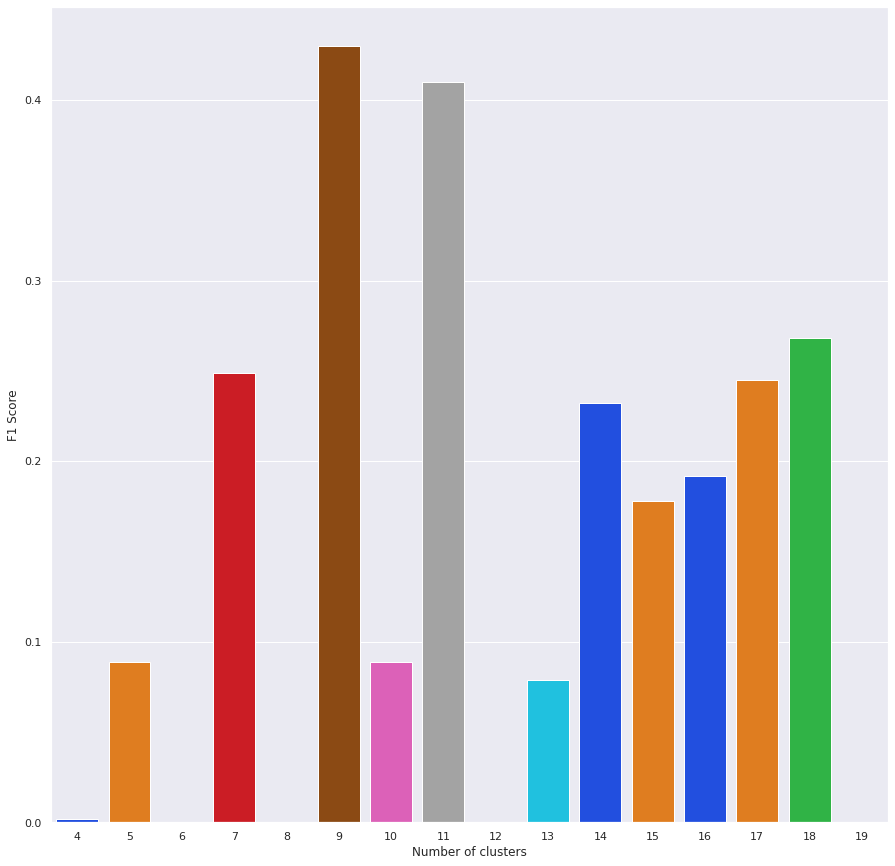

In [137]:
import pandas as pd
k_clusters = list(range(4, 20))

F1_score = [0.002, 0.089, 0.0, 0.249, 0.0, 0.430, 0.089, 0.410, 0.000, 0.079, 0.232, 0.178, 0.192, 0.245, 0.268, 0.000]
c_m = sns.color_palette("bright", len(set(F1_score)))
f1_df = pd.DataFrame({'Number of clusters':k_clusters, 'F1 Score':F1_score})
sns.barplot(x='Number of clusters', y='F1 Score', palette=c_m, data=f1_df)

In [22]:
# show_weights(clf, target_names=class_dict, vec=ctv)
# show_weights(clf, vec=ctv, top=100, feature_filter=lambda x: x != '<BIAS>')

In [23]:
booster = clf.get_booster()
original_feature_names = booster.feature_names
booster.feature_names = ctv.get_feature_names()
print(booster.get_dump()[0])
# recover original feature names
booster.feature_names = original_feature_names


0:[AEAH<-9.53674316e-07] yes=1,no=2,missing=1
	1:leaf=-0.0552932322
	2:leaf=0.491621971



In [24]:
# show_prediction(clf, doc=amino_df.values[100], vec=ctv)

In [105]:
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from lime import lime_text
from sklearn.pipeline import make_pipeline

#classes
class_names = list(class_dict.keys())

#make pipeline
pipe = make_pipeline(ctv, clf)

#instantiate explainer
explainer = LimeTextExplainer(class_names=class_names)

In [163]:
#Predict and analyze labelled data
def predict_analyze_labelled(idx ,vec ,model, pred_vec, pred_df_values, class_dict, highlight=False):
    '''
    idx - index of the row to analyze
    vec - instantiated vectorizer
    model - trained model
    pred_vec - vectorized prediction data
    pred_df_fvalues = the list of values used for vectorizing df[column].values
    class_names = list of calss names
    highlight - False=do not return highlighted text | True=return highlighted text
    '''
    #make pipeline
    pipe = make_pipeline(vec, model)

    #instantiate explainer
    explainer = LimeTextExplainer(class_names=class_dict.keys())
    
    print('Row ID: {}| Text : {}'.format(idx, pred_df_values[idx]))
    exp = explainer.explain_instance(pred_df_values[idx], pipe.predict_proba, num_features=4, labels=[0, 1, 2, ])
    pred_class = clf.predict(pred_vec[idx]).reshape(1,-1)[0,0]
    print('Predicted class =', class_dict[pred_class])
    print ('Explanation for class %s' % class_dict[pred_class])
    print ('\n'.join(map(str, exp.as_list(label=pred_class))))
    
    if highlight:
        exp.show_in_notebook(text=pred_df_values[idx], labels=(pred_class,))

In [111]:
predict_analyze_labelled(10, ctv, clf, xtest_ctv, xtest ,class_names, highlight=True)

Row ID: 10| Text : MAKNKSKRDAIALPENVPPPLQLFIHVAAAEEGHPKVTTYLGNYNLYATKAPPGVQVLSAKTSLTDFENVFGAQPTLRSIRNLVCEARSAEWTTSKNAFALKATQLDYSDAVLRAMIRFCPPKVSTLAAFALFGRLVKIEDKELAELARDTALELAYTAKIGTSLADTRSVSLIHKDAYLTLSNEVVGVTFTAALMAKATTVNGAMQYSNFYLYPRATIKVTDGKAEAIATKPLPAATKGKPITEDVNLLPDYQQLLVDQVTGTEVKVGALTYVKTADSPPLYFPKVKGGVIGIALKQQGTAAKKLNVVFHAQPDDVLLAFIQLQQLLNRTSDSSVEITACQSYEVSPTVTVKIGPSRPGDVIVATDEEYLKCFETPEVGRLYKVFQTQSWAIIERAFSSMKIRVSKALSAFISFLQNLADNFTAISGVVTALIRELQDLTLDVATRITNIQFVYRAGKLIVDTTSVIAKLFQPFCDFISPFLRKVAGFAIYTVGNRMLMFTSTGTFLLTKATTKILNKAKYIFDVEPEYPVDVTTSKVVVHEALQQIDTKPTRALEAVDVVVGNTVLQMATDGTAFYPSDGTHASLPGFKAGSDELFISFNCDLFDDETNAQINETLAAYELNQLVAPGDSTPRQIATLVVDTLADAITDHFPEKTIDLPEDYQVFSDHDDLPLAQYHIPDHLSLYIQAMEGEDDSGDEICIEDDDYDCPQADEDTEGVIPQQWELPDVDKFLLKIQERKTSSDEVLSVDVYPKPEPVGNVGIDDSASEKKPNGDPVPDPEVHPTLESVDVERPTETANQAVEDKPSDTTFVVDEEQLQESTPEHELRSYEGEFDSDDEIIIPIVPVTPADLKPQTITIKEYFKSEKLETINEGSTESVTQSDDSFDESFVDAESDDPQDPAVYDDTTIITDSTDVGDEPEITLATIVNTPLTLDNNLPPEAIKQPSPTKVELVVGELASIKFDNSVLVNPANAQLTNGG

/home/aneesh/Projects/covid_bh_ml/lib/python3.6/site-packages/lime/lime_text.py:114: FutureWarning:

split() requires a non-empty pattern match.



Predicted class = 3
Explanation for class 3


KeyError: 3

In [28]:
# clf.get_booster().get_score(importance_type="gain")


In [29]:
# fig, ax = plt.subplots(figsize=(12,18))
# xgb.plot_importance(clf, max_num_features=50, height=0.8, ax=ax)
# plt.show()

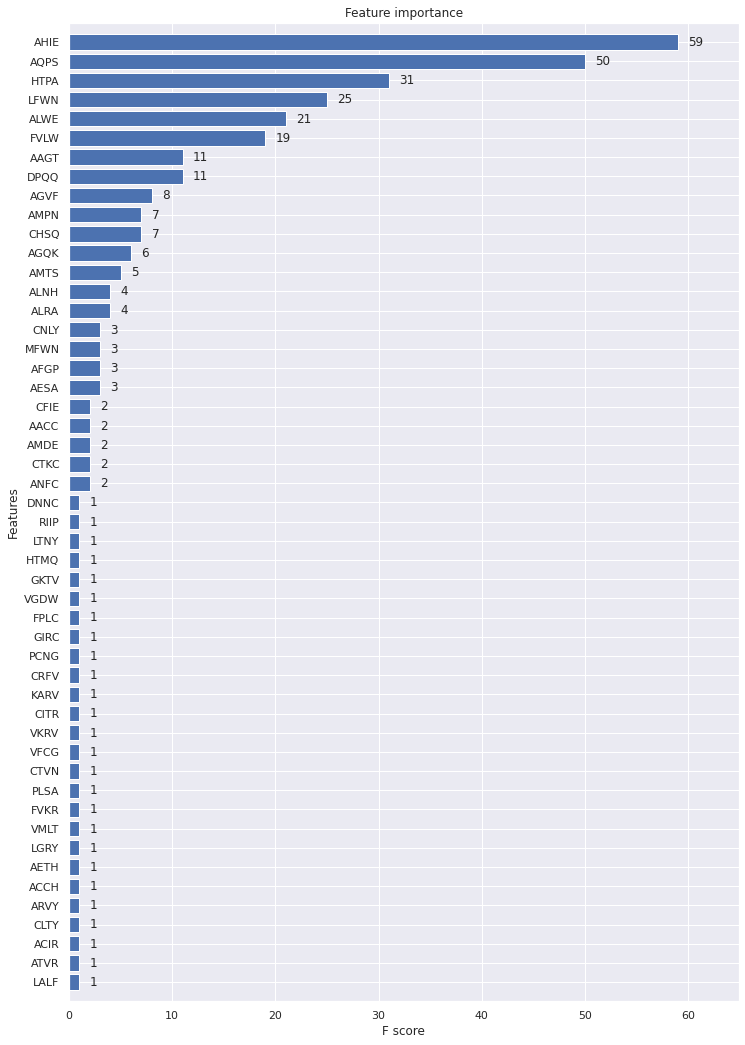

In [95]:
# feature importances
clf.get_booster().feature_names = ctv.get_feature_names()
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(clf.get_booster(), max_num_features=50, height=0.8, ax=ax)
plt.show()

In [96]:
def plot_scatter(color_by, x_tsne):
    # sns settings
    sns.set(rc={'figure.figsize':(15,15)})

    # colors
    palette = sns.color_palette("bright", len(set(color_by)))

    # plot
    sns.scatterplot(x_tsne[:,0], x_tsne[:,1], hue=color_by, legend='full', palette=palette)
    plt.title("t-SNE K-means clusters")
    # plt.savefig("plots/plot.png")
    plt.show()

In [97]:
def plot_tsne(xtrain_ctv, ytrain, perplexity):
    tsne = TSNE(verbose=1, perplexity=perplexity)
    x_tsne = tsne.fit_transform(xtrain_ctv)
    plot_scatter(ytrain, x_tsne)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 1870 samples in 0.040s...
[t-SNE] Computed neighbors for 1870 samples in 14.142s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1870
[t-SNE] Computed conditional probabilities for sample 1870 / 1870
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.126465
[t-SNE] KL divergence after 1000 iterations: 0.540755


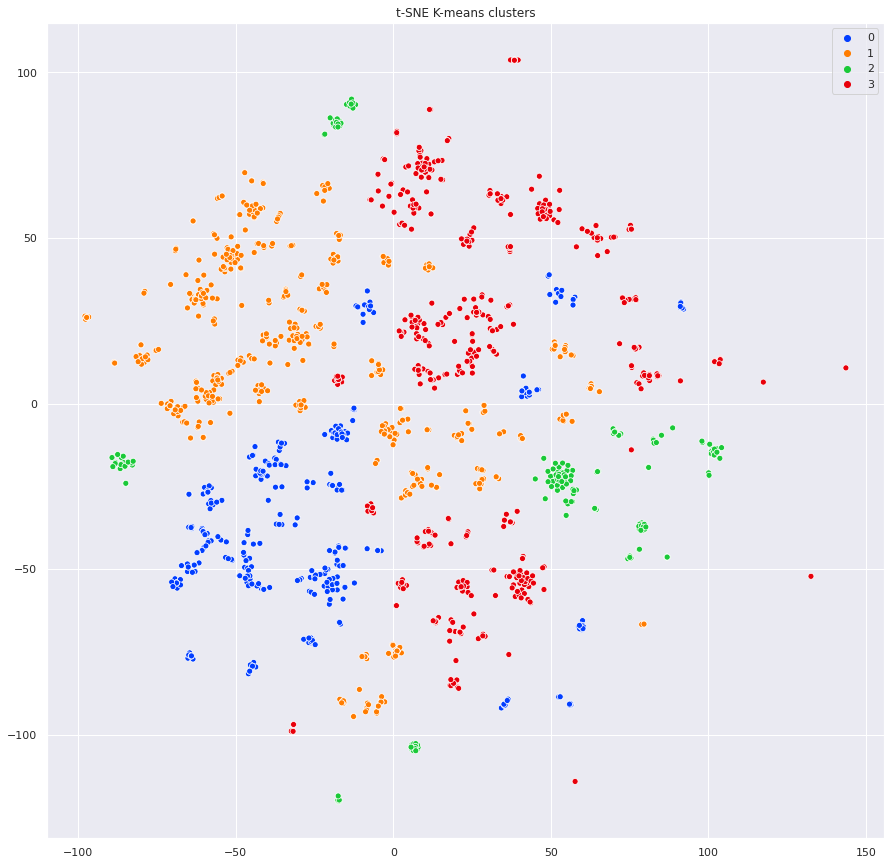

In [98]:
plot_tsne(xtrain_ctv, ytrain, 5)

[t-SNE] Computing 13 nearest neighbors...
[t-SNE] Indexed 1910 samples in 0.092s...
[t-SNE] Computed neighbors for 1910 samples in 14.552s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1910
[t-SNE] Computed conditional probabilities for sample 1910 / 1910
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.254608
[t-SNE] KL divergence after 1000 iterations: 0.588828


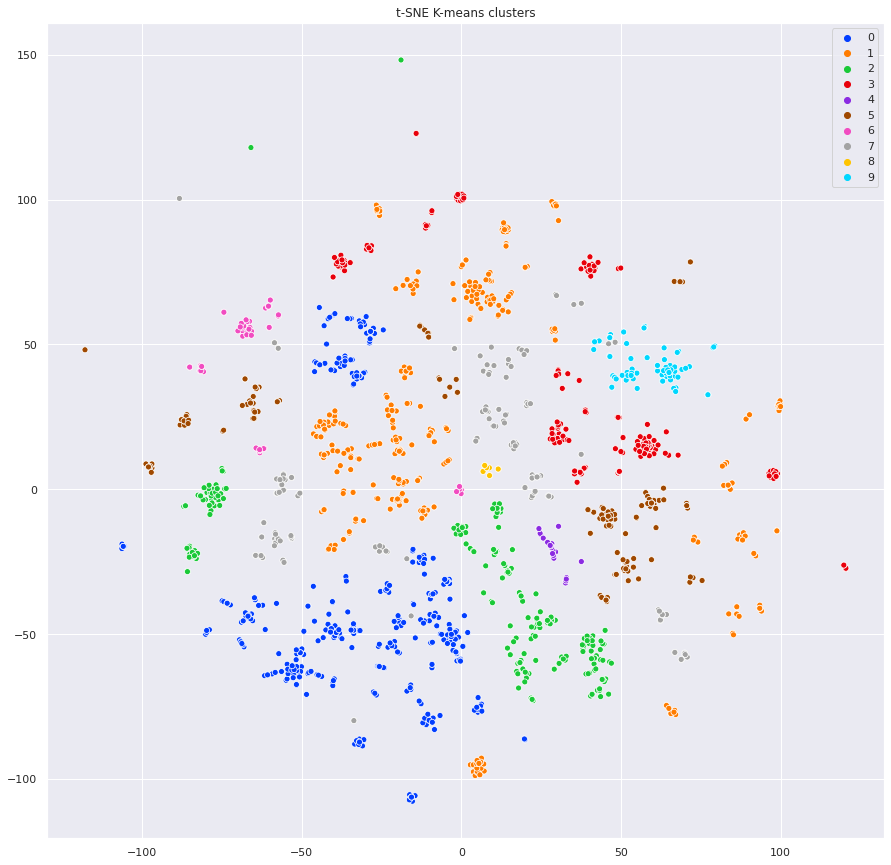

In [56]:
plot_tsne(xtrain_ctv, ytrain, 4)

[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 1910 samples in 0.039s...
[t-SNE] Computed neighbors for 1910 samples in 15.585s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1910
[t-SNE] Computed conditional probabilities for sample 1910 / 1910
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.393494
[t-SNE] KL divergence after 1000 iterations: 0.711996


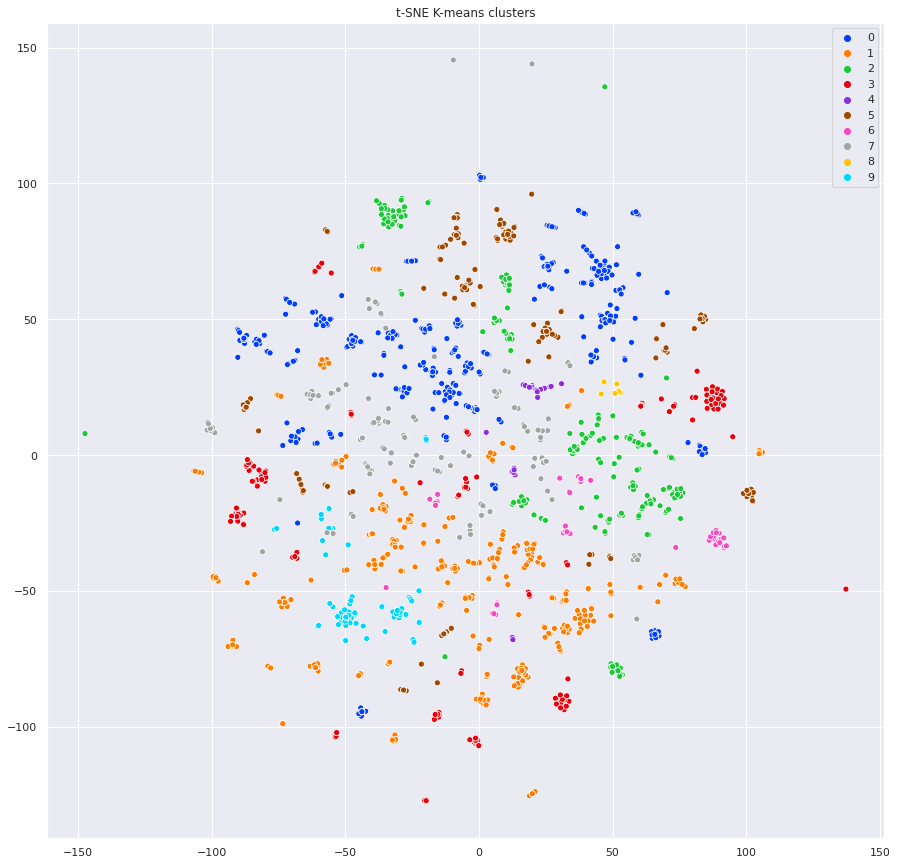

In [57]:
plot_tsne(xtrain_ctv, ytrain, 2)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 1910 samples in 0.086s...
[t-SNE] Computed neighbors for 1910 samples in 15.618s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1910
[t-SNE] Computed conditional probabilities for sample 1910 / 1910
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.272354
[t-SNE] KL divergence after 1000 iterations: 0.461604


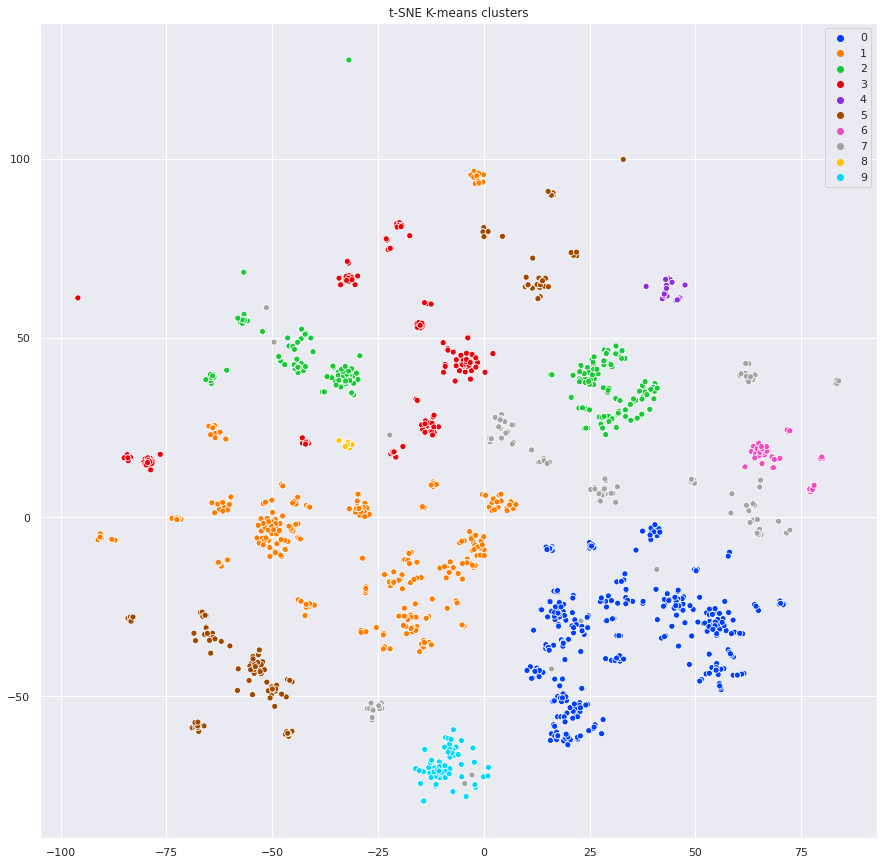

In [59]:
plot_tsne(xtrain_ctv, ytrain, 10)

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 1910 samples in 0.046s...
[t-SNE] Computed neighbors for 1910 samples in 14.456s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1910
[t-SNE] Computed conditional probabilities for sample 1910 / 1910
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.519608
[t-SNE] KL divergence after 1000 iterations: 0.418497


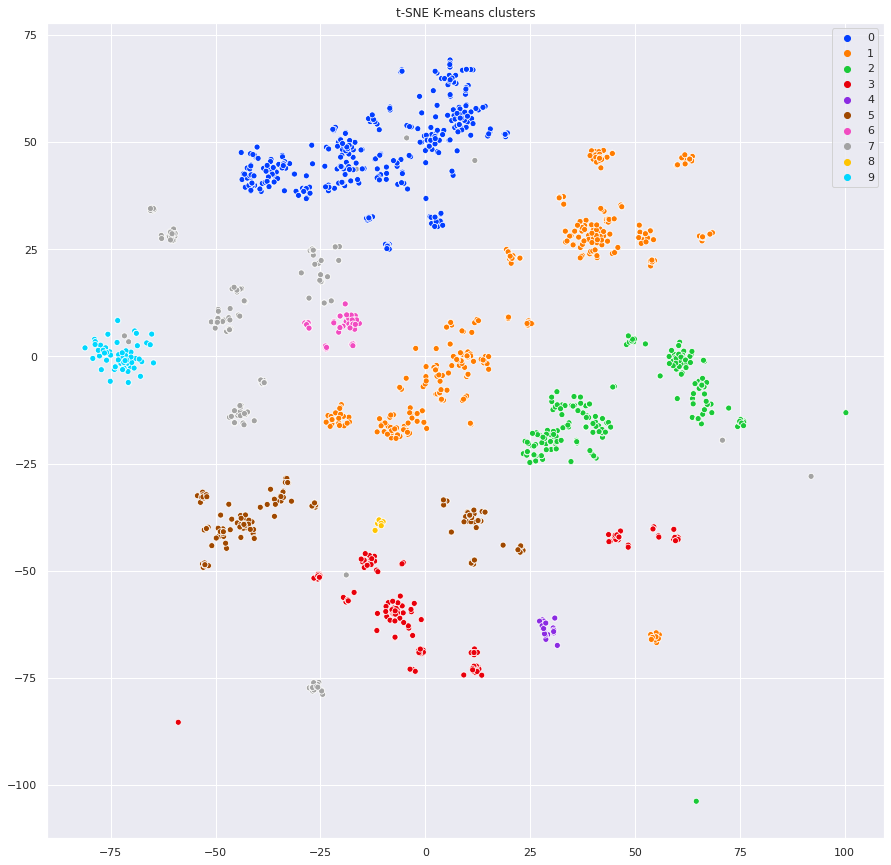

In [60]:
plot_tsne(xtrain_ctv, ytrain, 15)

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 1870 samples in 0.039s...
[t-SNE] Computed neighbors for 1870 samples in 14.286s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1870
[t-SNE] Computed conditional probabilities for sample 1870 / 1870
[t-SNE] Mean sigma: 4.324926
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.630386
[t-SNE] KL divergence after 1000 iterations: 0.350292


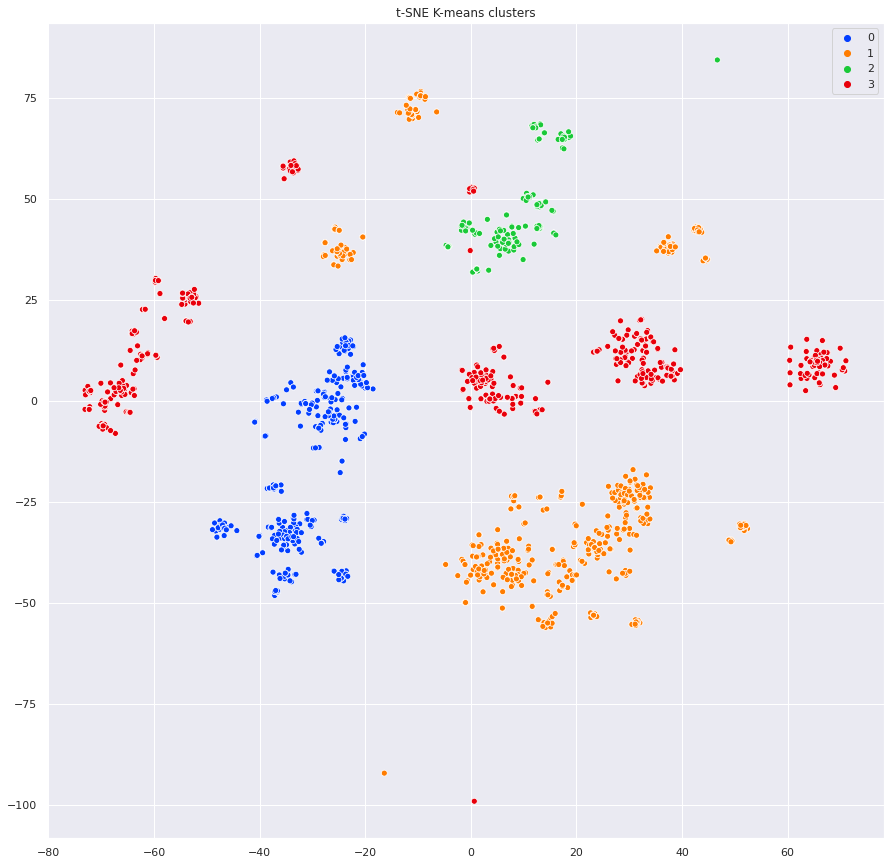

In [99]:
plot_tsne(xtrain_ctv, ytrain, 25)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1870 samples in 0.037s...
[t-SNE] Computed neighbors for 1870 samples in 15.021s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1870
[t-SNE] Computed conditional probabilities for sample 1870 / 1870
[t-SNE] Mean sigma: 5.472023
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.685268
[t-SNE] KL divergence after 1000 iterations: 0.285305


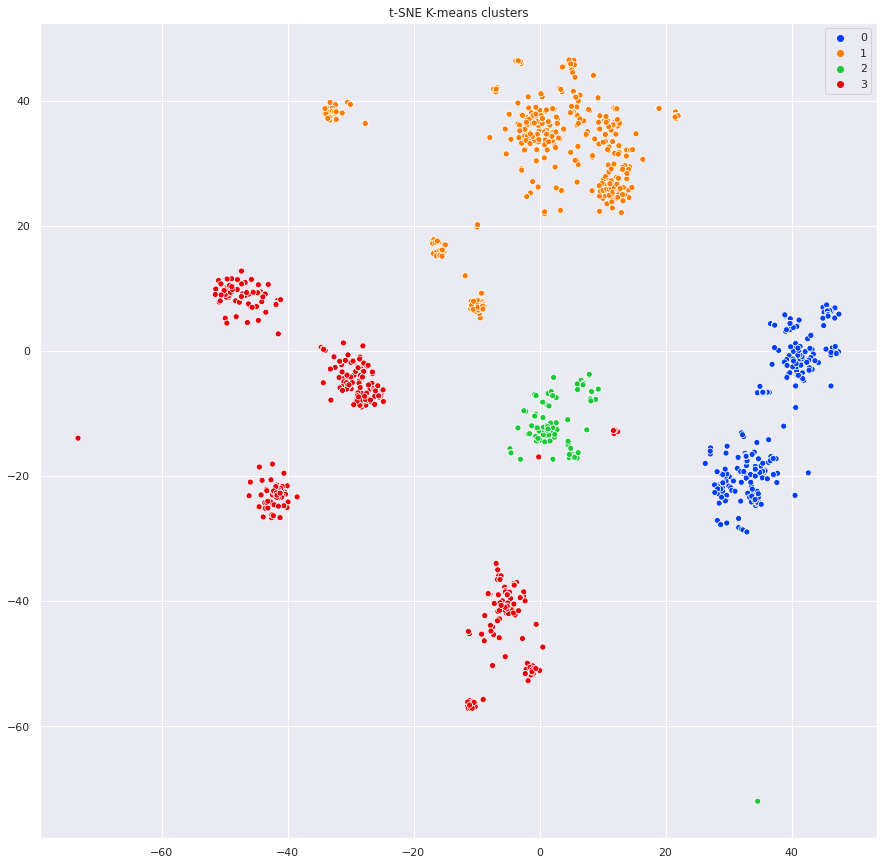

In [100]:
plot_tsne(xtrain_ctv, ytrain, 50)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 1870 samples in 0.036s...
[t-SNE] Computed neighbors for 1870 samples in 14.187s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1870
[t-SNE] Computed conditional probabilities for sample 1870 / 1870
[t-SNE] Mean sigma: 7.058826
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.200943
[t-SNE] KL divergence after 1000 iterations: 0.204600


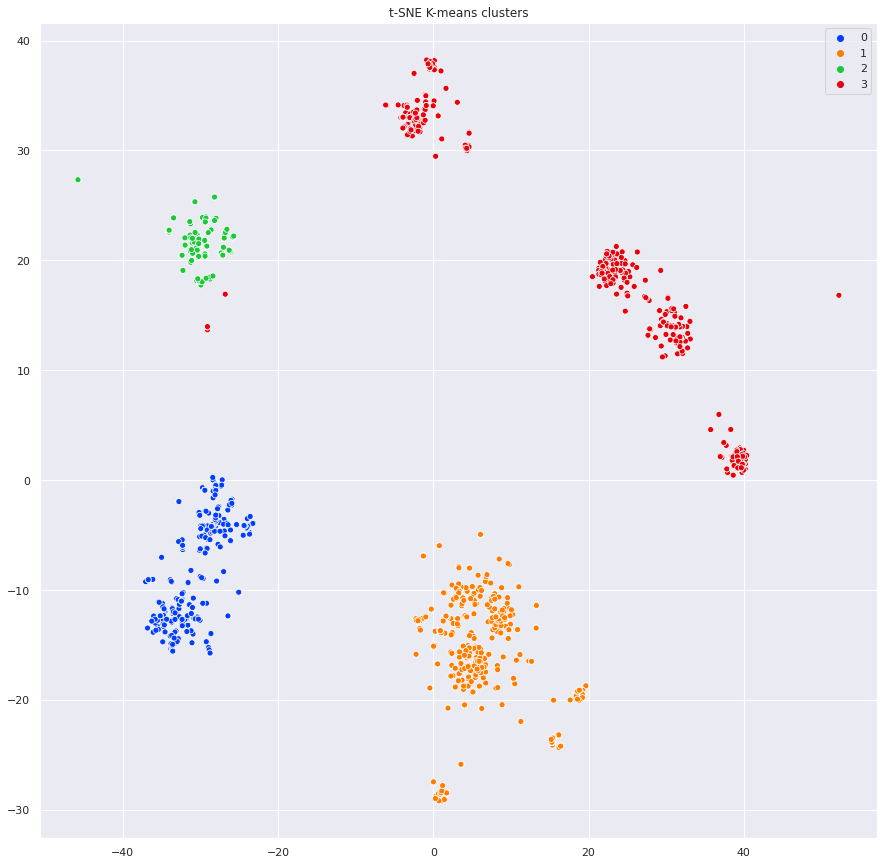

In [101]:
plot_tsne(xtrain_ctv, ytrain, 100)

[t-SNE] Computing 601 nearest neighbors...
[t-SNE] Indexed 1870 samples in 0.037s...
[t-SNE] Computed neighbors for 1870 samples in 14.628s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1870
[t-SNE] Computed conditional probabilities for sample 1870 / 1870
[t-SNE] Mean sigma: 10.241513
[t-SNE] KL divergence after 250 iterations with early exaggeration: 41.093239
[t-SNE] KL divergence after 1000 iterations: 0.156100


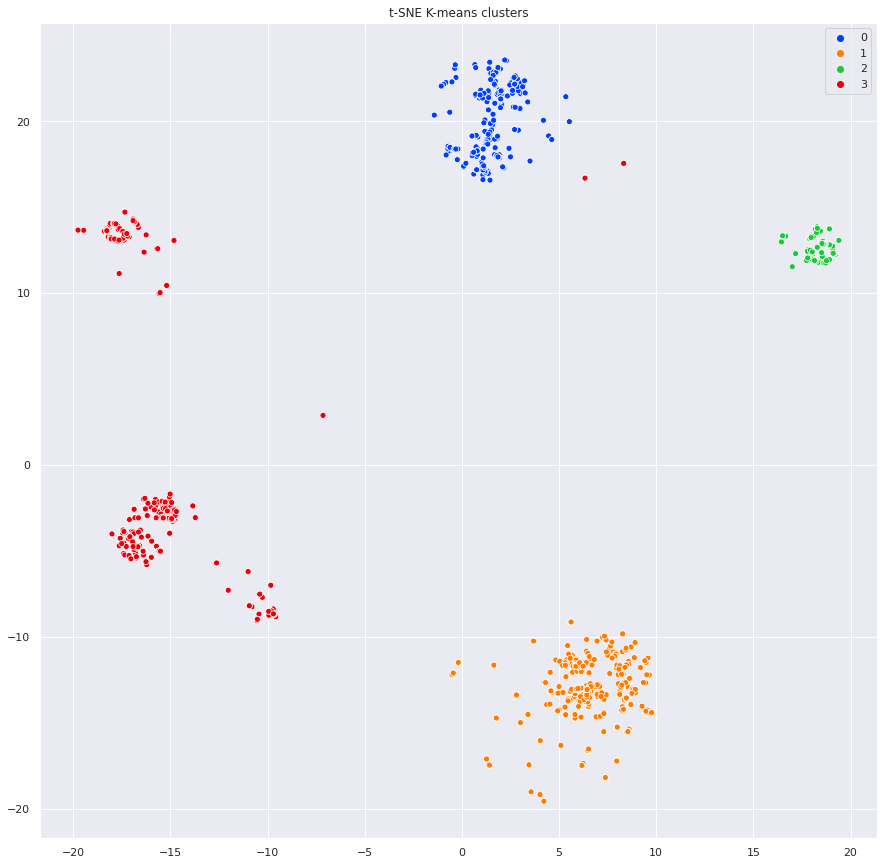

In [102]:
plot_tsne(xtrain_ctv, ytrain, 200)

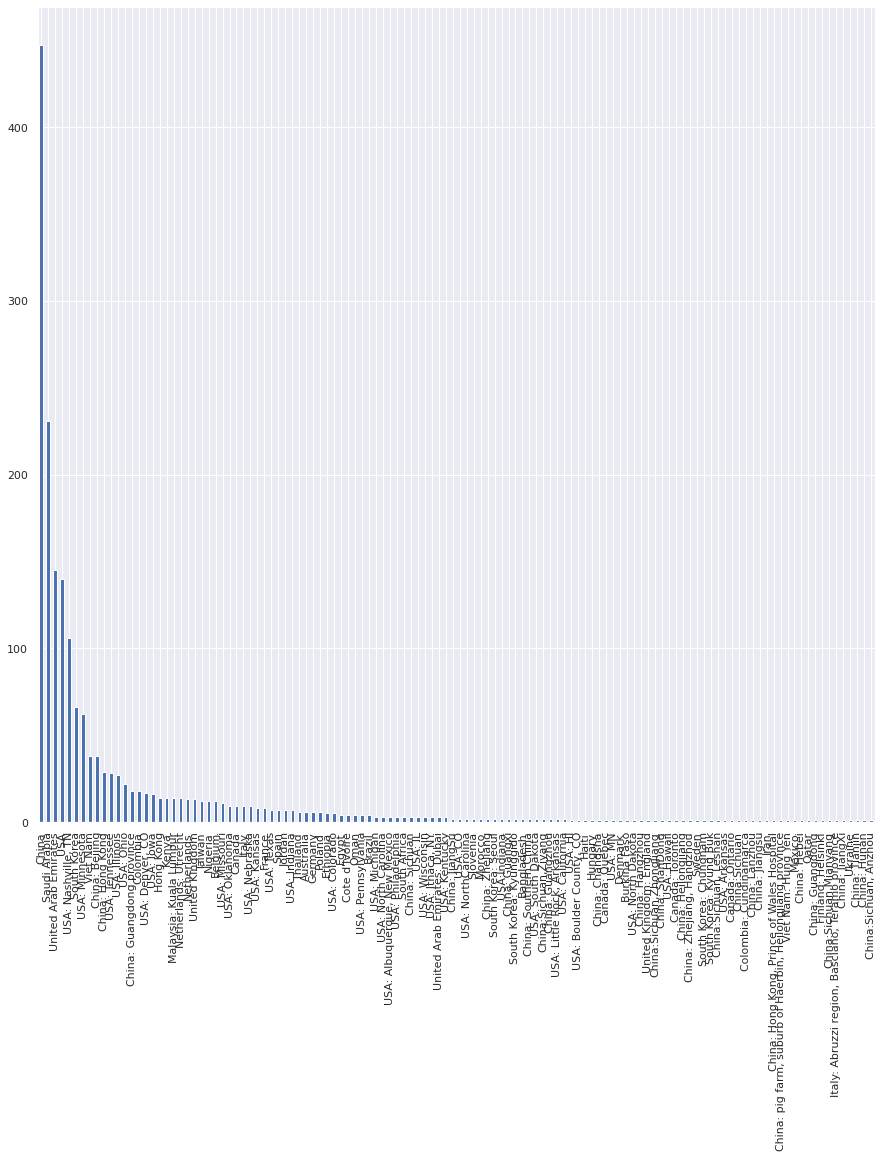

In [54]:
train_df['Geo_Location'].value_counts().plot(kind='bar')

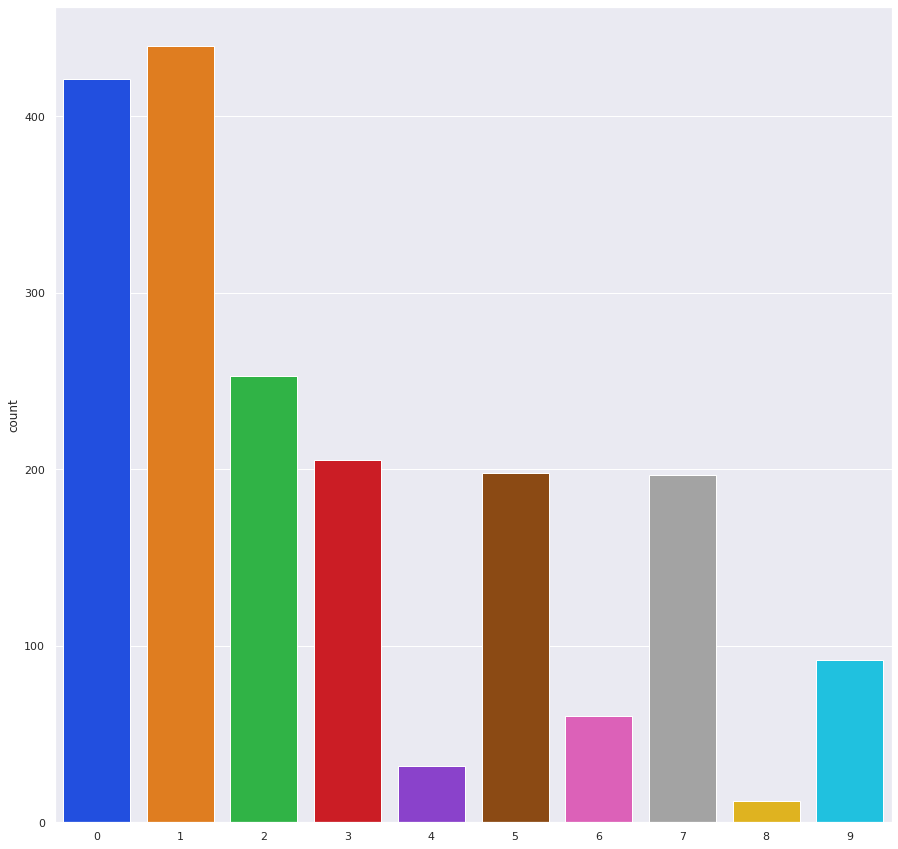

In [70]:
sns.countplot(ytrain, palette = sns.color_palette("bright", len(set(ytrain))))

In [68]:
print(ytrain)

[5 9 1 ... 3 3 3]


In [73]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(xtrain_ctv)
  labels = kmeans.labels_
  sil.append(silhouette_score(xtrain_ctv, labels, metric = 'euclidean'))

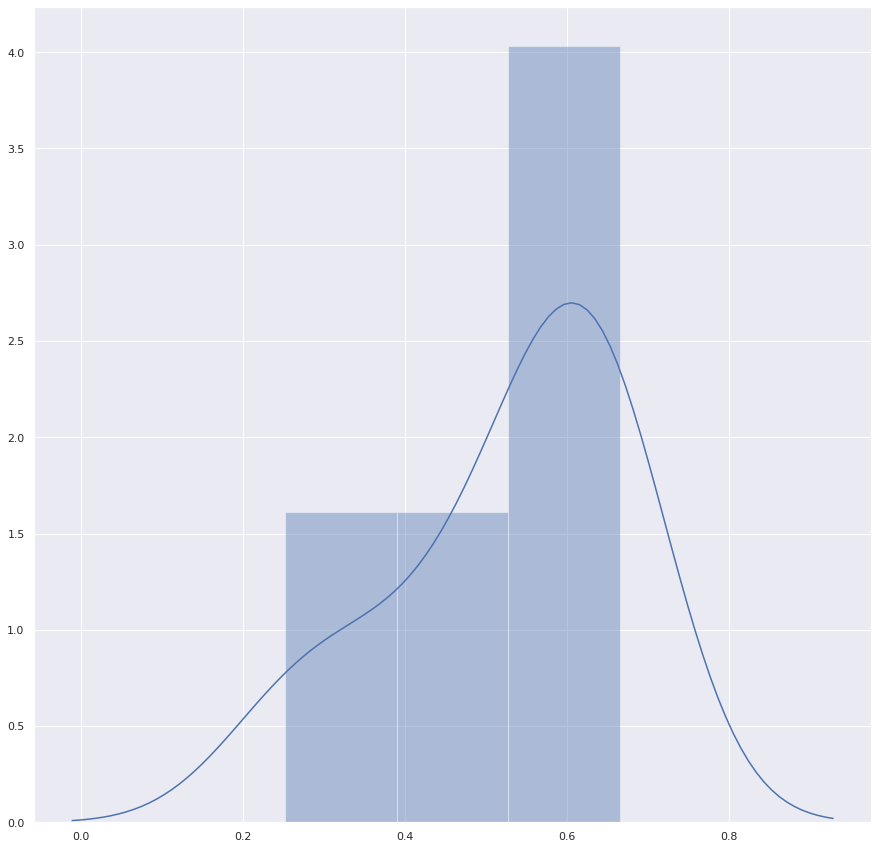

In [76]:
sns.distplot(sil, )

In [78]:
# function returns WSS score for k values from 1 to kmax
def calculate_WSS(points, kmax):
  sse = []
  for k in range(1, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(points)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)
    curr_sse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(points.shape[0]):
      curr_center = centroids[pred_clusters[i]]
      curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
    sse.append(curr_sse)
  return sse

sse = calculate_WSS(xtrain_ctv, kmax)

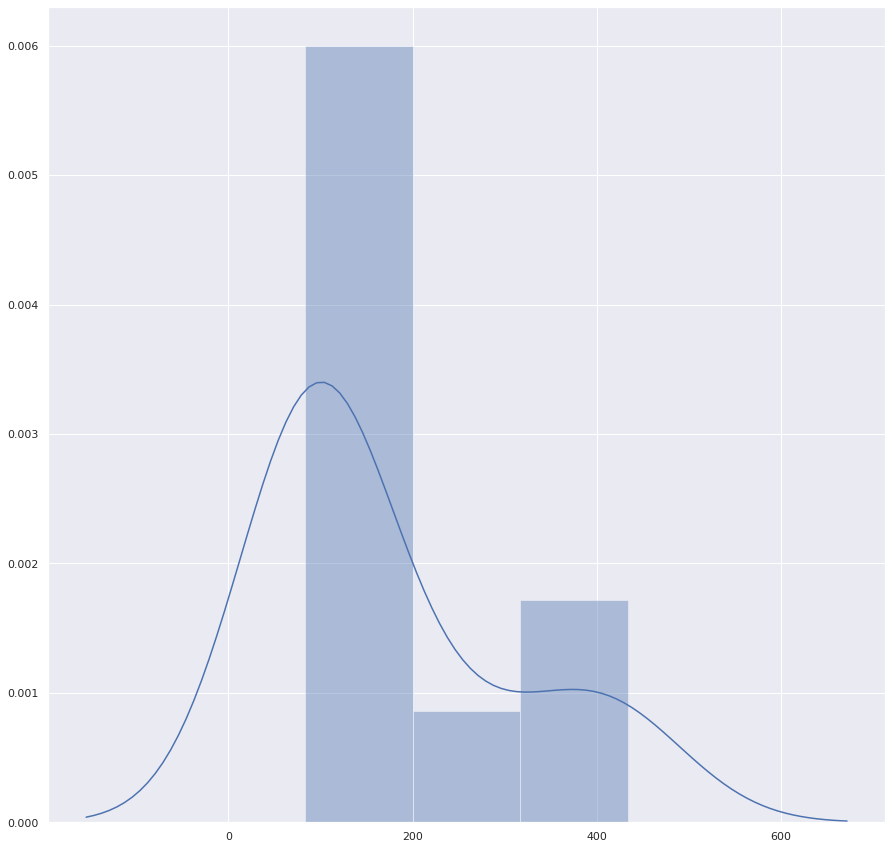

In [79]:
sns.distplot(sse)

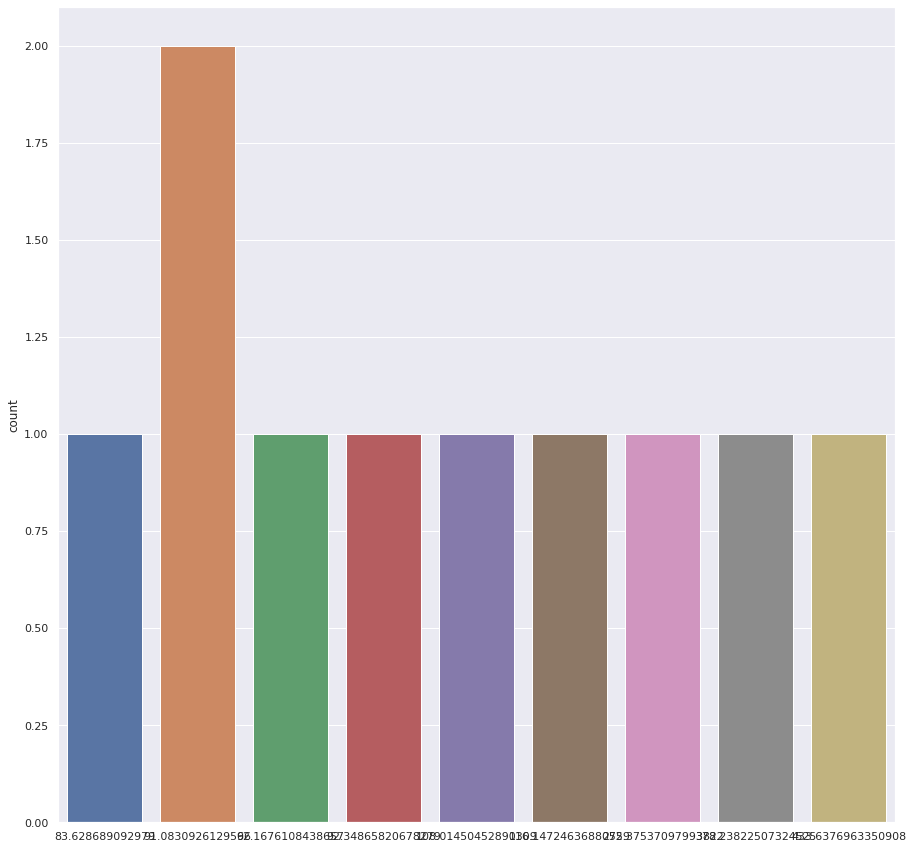

In [80]:
sns.countplot(sse)